In [ ]:
%env THEANO_FLAGS=device=gpu2
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

In [ ]:
from utils.southpark import get_conversations
conversations = get_conversations("/srv/hd7/jheuristic/cartman/sp.json")
    
from utils.preprocessor import Preprocessor

preproc = Preprocessor.from_conversations(conversations,verbose=True)


# model

In [3]:
from models.context_model import ConversationModelCTX
ctx_window,ctx_line_len = 3,10

model = ConversationModelCTX(preproc,(None,ctx_window,ctx_line_len),bottleneck_size=512)

Using gpu device 2: Tesla K40m (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 4004.)
/home/jheuristic/thenv/local/lib/python2.7/site-packages/agentnet/agent/recurrence.py:228: UserWarning: You are giving Recurrence an input sequence of undefined length (None).
Make sure it is always above <unspecified>(n_steps) you specified for recurrence
  "Make sure it is always above {}(n_steps) you specified for recurrence".format(n_steps or "<unspecified>"))
/home/jheuristic/thenv/local/lib/python2.7/site-packages/agentnet/agent/recurrence.py:453: UserWarning: Warning: recurrent loop without unroll_scan got nonempty random state updates list. That happened because there is some source of randomness (e.g. dropout) inside recurrent step graph. To compile such graph, one must either call .get_automatic_updates() right after .get_output and pass these updates to a function, or use no_defalt_updates=True when compiling theano.function.
  warn("Warning: recurrent loop without unroll_sc

# training

In [4]:
max_len=30
batch_size=100
n_epochs=100

In [5]:
from utils.generate import get_samples_with_context,iterate_minibatches

convs_ix = list(preproc.preprocess_conversations(conversations,verbose=True,max_len=max_len))

import numpy as np
prev_ctx,prev_phrases,reference_answers = map(np.stack,
                                              get_samples_with_context(convs_ix,context_window_size=ctx_window,
                                                                       padder = preproc.token_to_ix["PAD"],
                                                                       speaker_filter = lambda s1,s2: 'cartman' in s2).T
                                             )
prev_ctx = prev_ctx[:,:,:ctx_line_len]
prev_ctx,prev_phrases,reference_answers= map(lambda v: v.astype('int32'),[prev_ctx,prev_phrases,reference_answers])

100%|██████████| 7285/7285 [00:04<00:00, 1593.50it/s]


In [6]:
epoch_counter = 1
ce = []

4725 iterations...
4750 iterations...
4775 iterations...
beginning new loop...


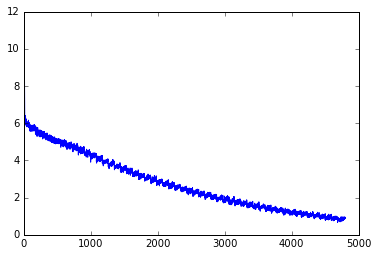

A: oh gohhhd .
B: ma'am , ma'am . , kyle's mom . , ma'am . ? . . we , ma'am , ma'am . , ma'am , butters ? , ma'am . , ma'am , , ma'am . i , ma'am . , ma'am . , ma'am the are ?
B true: we need to speak with you , ma'am .
4800 iterations...
4825 iterations...
4850 iterations...
4875 iterations...
beginning new loop...


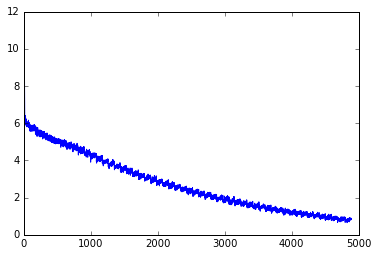

A: go in there ? uh , but they'll see me .
B: ey ! i am a plan . , i a . these . . . have to kick my house . i have to have your plan . . . . have it ? . . . i i have i have it . i huh ? i want ! i , .
B true: don't worry . i have a plan .
4900 iterations...
4925 iterations...
4950 iterations...
4975 iterations...
beginning new loop...


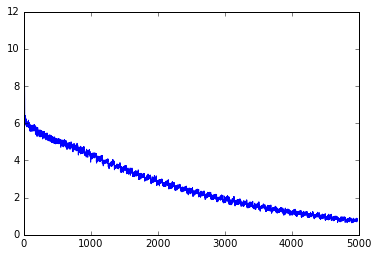

A: sixteen dollars ! take it ! i - i'll even throw in an extra five ! here ! give me back my pubes !
B: man ! , go on . . . . i i i'm i
B true: wha - ? uh oo
5000 iterations...
5025 iterations...
5050 iterations...
beginning new loop...


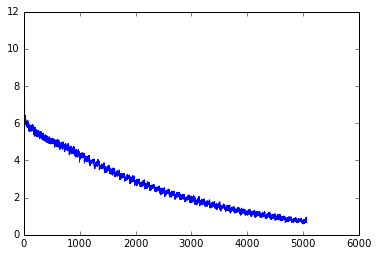

A: sorry !
B: christ - aw ! - ! - i kick your penis - uh ! one - - and i made your parents ! your i'm gonna go -
B true: - and then tried to fuck me out of your business !
5075 iterations...
5100 iterations...
5125 iterations...
5150 iterations...
beginning new loop...


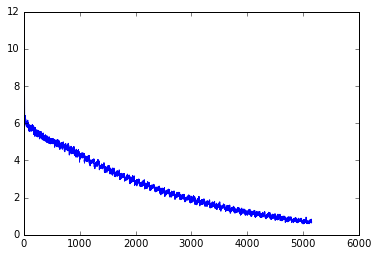

A: mr . jefferson , i have to go to school tomorrow !
B: hell son ! and , this ! what you're now ! now , the ugh , and i'll tell you what your father is . .
B true: oh , son of a bitch ! i knew it ! what the hell are you doing , stan ? ! i'll tell you what you're doing ! you're
5175 iterations...
5200 iterations...
5225 iterations...
beginning new loop...


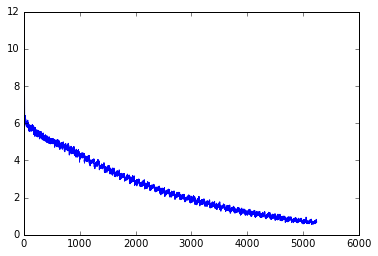

A: thank you .
B: kid kenny is like this kid by your ring like , " shit " hm " cut up the fuck it ? i'm i ,
B true: duhude , dude ,
5250 iterations...
5275 iterations...
5300 iterations...
5325 iterations...
beginning new loop...


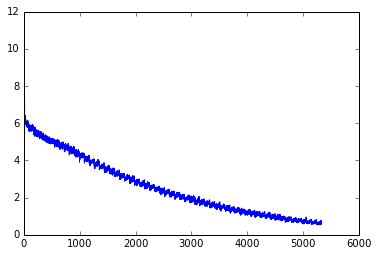

A: we don't have time for that , dude ! we just have to ditch them ! now !
B: yes . , let us a blood just one over blood . but if you just get the wall - then that you are ! we it that .
B true: okay . go ahead , kyle . throw your nunchucks away . if you can . but you know damn well that your jewish blood won't let you .
5350 iterations...


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
for _ in range(n_epochs):
    for b_c,b_x,b_y in iterate_minibatches([prev_ctx,prev_phrases,reference_answers],batch_size,shuffle=True):
        ce.append(model.train_fun(b_c,b_x,b_y))
        
        epoch_counter +=1
        
        if epoch_counter %25==0:
            print epoch_counter,'iterations...'
    print "beginning new loop..."
    plt.plot(ce)
    plt.show()
    
    ph =preproc.ix_to_phrase(b_x[0])
    print 'A:', ph
    print 'B:', model.reply(ph)
    print 'B true:',preproc.ix_to_phrase(b_y[0])
        

In [10]:
model.reply("Who are you?")

u'kill those i am the big kid now i want , mr . no . " my dad the dawg ? i , let\'s never take back the big . . . it\'s the big mean . i and . i\'m the . . . we\'re so cool ! . . . , i\'m your living away ! and him ?'

In [ ]:
from agentnet.utils.persistence import save
save(model.decoder_training_rec,"/srv/hd7/jheuristic/agentnet_snapshots/southpark_context_cm_cartman_epoch%i.pcl"%epoch_counter)